In [6]:
import copy
from collections.abc import Iterable
import functools
import itertools
import operator
from matplotlib import pyplot as plt

import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import numpy_ext as npe
import math
import random
from pprint import pprint
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.sparse import hstack, vstack, csr_matrix
import scipy

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import joblib
import seaborn as sns

import utils
import safety
import ope

import sys

from config import demographics, vital_sign_vars, lab_vars, treatment_vars, vent_vars, guideline_vars, ffill_windows_clinical, SAMPLE_TIME_H
from config import fio2_bins, peep_bins, tv_bins

In [113]:
test_set_file = 'data/test_unshaped_traj_{}.csv'
train_set_file = 'data/train_unshaped_traj_{}.csv'

q_fname = 'models/peine_mc_{}_q_table_{}.bin'
greedy_policy_file = 'models/mcp_greedy_policy_{}{}.bin'
sm_policy_file = 'models/mcp_softmax_policy_{}{}.bin'
linear_policy_file = 'models/mcp_linear_policy_{}{}.bin'
behavior_policy_train_file = 'models/clinicians_policy_train_{}{}.bin'
behavior_policy_test_file = 'models/clinicians_policy_test_{}{}.bin'
behavior_policy_file = 'models/clinicians_policy_train_test_{}{}.bin'

N_BOOT = 2000
seed = 5
shaping = 'unshaped'
n_states = 650
seeds = range(20)

In [332]:
def inv_softmax(x, C):
    return np.log(x) + C

def inf_to_nan(x):
    y = x.copy()
    y[y == float('-inf')] = np.nan
    return y

def nan_inv_softmax(x, C):
    scores = inv_softmax(x, C)
    scores_nan = inf_to_nan(scores)
    return scores_nan

def nansoftmax(x, c=float('-inf')):
    y = x.copy()
    y[np.isnan(y)] = c
    return scipy.special.softmax(y, axis=1)

q_file = joblib.load(q_fname.format(shaping, seed))
q_table_nan = q_file['model']
q_table = np.nan_to_num(q_table_nan, 0.0)
q_table_neg = q_table_nan.copy()
q_table_neg[q_table_neg == 0.0] = float('-inf')
t = 1.0
q_table_nan[q_table_nan == 0.0] = np.nan

sm_unsafe = scipy.special.softmax(q_table_neg / t, axis=1)
q_retrieved = inv_softmax(sm_unsafe, 1)
q_retrieved_nan = inf_to_nan(q_retrieved)

/tmp/ipykernel_845427/3928049307.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x) + C


In [133]:
xs = []
y_l = []
y_u = []
for c in range(-200, 200, 10):
    xs += [c,]
    retrieved_q = nan_inv_softmax(sm_unsafe, c)
    y_l += [np.nanmin(retrieved_q),]
    y_u += [np.nanmax(retrieved_q),]

xs = np.array(xs)
y_l = np.array(y_l)
y_u = np.array(y_u)

/tmp/ipykernel_845427/4244123466.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x) + C


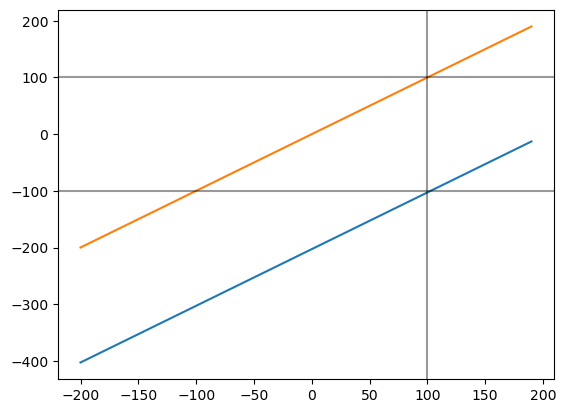

In [188]:
sns.lineplot(x=xs, y=y_l)
sns.lineplot(x=xs, y=y_u)
plt.axhline(100, c='black', alpha=.4)
plt.axhline(-100, c='black', alpha=.4)
plt.axvline(100, c='black', alpha=.4)
plt.show()

In [198]:
c = 100
y_l[xs==100], y_u[xs==100]

(array([-102.88109341]), array([100.]))

In [298]:
c = 100
q_retrieved_nan = nan_inv_softmax(sm_unsafe, c)

/tmp/ipykernel_845427/3800127286.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x) + C


In [299]:
np.nanmin(q_retrieved_nan), np.nanmax(q_retrieved_nan)

(-102.88109341341467, 100.0)

In [300]:
np.nanmin(q_retrieved_nan - q_table_nan), np.nanmax(q_retrieved_nan - q_table_nan)

(-2.8810934134153854, 199.9999999999993)

In [301]:
np.nanmin(q_retrieved_nan - q_table_nan), np.nanmax(q_retrieved_nan - q_table_nan)

(-2.8810934134153854, 199.9999999999993)

In [302]:
assert not (np.isnan(q_retrieved_nan) & ~np.isnan(q_table_nan)).any()
np.nanmin(q_retrieved_nan - q_table_nan), np.nanmax(q_retrieved_nan - q_table_nan)

(-2.8810934134153854, 199.9999999999993)

In [303]:
min_or_max = np.nanargmax

state, action = np.unravel_index(min_or_max(q_retrieved_nan - q_table_nan), q_retrieved_nan.shape)
for i, (ar, at) in enumerate(zip(q_retrieved_nan[state, :], q_table_nan[state, :])):
    print(ar, at, end = '')
    if i == action:
        print('<<<<<')
    else:
        print('')


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


In [304]:
np.nanmax(q_table), np.nanmin(q_table)

(99.99999999999929, -99.99999999999929)

In [305]:
diffs = (q_retrieved_nan - q_table_nan)

<AxesSubplot: ylabel='Count'>

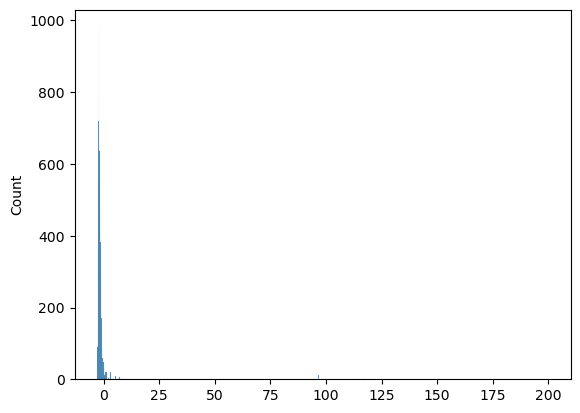

In [306]:
sns.histplot((diffs.ravel()[~np.isnan(diffs.ravel())]))

In [310]:
state=56
for i, (ar, at) in enumerate(zip(q_retrieved_nan[state, :], q_table_nan[state, :])):
    if not (np.isnan(ar) and np.isnan(at)):
        print(ar, at)

96.60691985049974 98.00999999999789
96.62642772256746 98.02950787206561
96.61662477178004 98.01970492127819
96.6699543678403 98.07303451733846
96.60691985049974 98.00999999999789
97.27023085013016 98.67331099962831
96.60691985049974 98.00999999999789
96.60691985049974 98.00999999999789
96.60691985049974 98.00999999999789
96.60691985049974 98.00999999999789
96.60691985049974 98.00999999999789
96.60691985049974 98.00999999999789
30.9391308871665 32.342211036664644
96.60691985049974 98.00999999999789
96.60691985049974 98.00999999999789
96.60691985049974 98.00999999999789
96.90747189110894 98.31055204060709
96.93690873976342 98.33998888926158
96.60691985049974 98.00999999999789
97.59691985050043 98.99999999999858
96.60691985049974 98.00999999999789
96.61017072951675 98.0132508790149
87.09247308043442 88.49555322993257
96.8581634428372 98.26124359233535
96.60691985049974 98.00999999999789
96.60691985049974 98.00999999999789
96.60691985049974 98.00999999999789
96.60691985049974 98.0099999999

In [358]:
# q_train = q_retrieved_nan.copy()
q_train = np.zeros(q_table.shape)
q_target = q_table_nan.copy()

In [359]:
q_train[state, safety.action_id_compliance]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [362]:
def learning_step(q_train, q_target, learning_rate=0.1):
    return q_train + (learning_rate * (q_target - q_train))

def constrained_learning_step(q_train, q_target, learning_rate=0.5, safety_map=safety.action_id_compliance):
    

step_1 = learning_step(q_train, q_target, learning_rate=.1)

In [370]:
state=56
for i, (ar, at, att) in enumerate(zip(q_train[state, :], step_1[state, :], q_target[state,:])):
    if not (np.isnan(ar) and np.isnan(at)):
        print(ar, at, att)

0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 9.800999999999789 98.00999999999789
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan
0.0 nan nan


In [371]:
step1_p = nansoftmax(step_1)
train_p = nansoftmax(q_train)
target_p = nansoftmax(q_target)

In [381]:
target_p[65, safety.action_id_compliance].sum()

0.5486810671613165

In [384]:
(step1_p - target_p)[state,:]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [401]:
target_log_sm = np.log(target_p)
target_cs = np.abs(np.nanmin(q_target, axis=1))
target_log_sm + np.tile(target_cs, target_p.shape[1]).reshape(target_p.shape)

/tmp/ipykernel_845427/3870119016.py:1: RuntimeWarning: divide by zero encountered in log
  target_log_sm = np.log(target_p)


array([[-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       ...,
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf]])

In [411]:
np.log(0.1) + 100

97.69741490700595

In [416]:
np.log(0.1) + 0.0

-2.3025850929940455

In [418]:
q_train[0,0] = -2.3025850929940455

In [437]:
for s in range(q_train.shape[0]):
    q_train[s,:] = np.random.normal(0.0, scale=.01, size=q_train.shape[1])
np.log(0.1) + q_train[0,:].min()

-2.326711431016401

In [438]:
q_train[0,0] = -2.275911343017511

In [439]:
p_train = scipy.special.softmax(q_train)
p_train[0,:]

array([4.60635559e-07, 4.52030015e-06, 4.47176470e-06, 4.46938492e-06,
       4.51979011e-06, 4.50684160e-06, 4.55887875e-06, 4.48112170e-06,
       4.49460144e-06, 4.57881863e-06, 4.46462026e-06, 4.52418428e-06,
       4.44879859e-06, 4.50388406e-06, 4.57200701e-06, 4.39849531e-06,
       4.48241444e-06, 4.51894361e-06, 4.48258047e-06, 4.48062626e-06,
       4.55706501e-06, 4.48712285e-06, 4.47177852e-06, 4.47832366e-06,
       4.46381682e-06, 4.49738526e-06, 4.43697662e-06, 4.49713397e-06,
       4.45591390e-06, 4.38719547e-06, 4.50504805e-06, 4.45477544e-06,
       4.44576656e-06, 4.54956783e-06, 4.51576768e-06, 4.45153466e-06,
       4.46893437e-06, 4.47806037e-06, 4.55541231e-06, 4.49753966e-06,
       4.56655794e-06, 4.44977959e-06, 4.50433431e-06, 4.51041247e-06,
       4.53609102e-06, 4.44113862e-06, 4.57369059e-06, 4.48573775e-06,
       4.51288229e-06, 4.50504230e-06, 4.52919141e-06, 4.54219848e-06,
       4.54961172e-06, 4.43839881e-06, 4.47719250e-06, 4.42865067e-06,
      

In [436]:
p_train = np.random.normal(0.0, scale=.01, size=q_train.shape[1])

In [448]:
q_train = np.random.normal(0.0, scale=1, size=4)
p_train = scipy.special.softmax(q_train, axis=0)

In [465]:
q_train

array([-0.38573517, -0.53020672,  0.38726019, -0.74852685])

In [455]:
p_train
np.log(p_train) + q_train.max()

array([-1.16612705, -1.31059859, -0.39313169, -1.52891873])

In [456]:
c = np.log((np.exp(q_train)).sum())

In [463]:
np.log(p_train) + c

array([-0.38573517, -0.53020672,  0.38726019, -0.74852685])

In [461]:
max_unsafe_q = np.log(.3) + c

In [473]:
smap = np.array([False, False, True, True])

In [480]:
max_q  = np.log(1) + c

In [484]:
max_safe_q = np.log(.7) + c

In [485]:
max_safe_q

0.8109771258733989

In [474]:
max_unsafe_q / (q_train[~smap] / q_train[~smap].sum())

array([-0.08624488, -0.06274474])

In [486]:
q_train_safe_adjust = q_train.copy()
q_train_safe_adjust[~smap] = max_unsafe_q / (q_train[~smap] / q_train[~smap].sum())
q_train_adjust = q_train_safe_adjust.copy()
q_train_adjust[smap] = max_safe_q / (q_train[smap] / q_train[smap].sum())

In [489]:
q_train_adjust.sum(), q_train.sum()

(-0.5141251734822341, -1.277208549740939)

In [492]:
q_train

array([-0.38573517, -0.53020672,  0.38726019, -0.74852685])

In [478]:
q_train_safe_adjust

array([-0.08624488, -0.06274474,  0.38726019, -0.74852685])

In [479]:
q_train_safe_adjust.sum()

-0.5102562736525782

In [532]:
p_train

array([0.21153025, 0.18307511, 0.45822641, 0.14716823])

In [632]:
# TODO: scale/calibrate probabilities multiple unsafe actions
# TODO: include temperature parameter
safety_matrix = np.array([False, False, True, True])
max_unsafe = .5
max_adjust = min(p_train[0], max_unsafe)
q_train_adjust = q_train.copy()
q_train_adjust[~safety_matrix] = np.log(max_adjust / (~safety_matrix).sum()) + c
q_train_adjust[safety_matrix] += (q_train[~safety_matrix] - q_train_adjust[~safety_matrix]).sum() / len(q_train_adjust[safety_matrix])
p_adjust = scipy.special.softmax(q_train_adjust)
p_adjust, p_adjust[~safety_matrix].sum()

(array([0.07905064, 0.07905064, 0.6372376 , 0.20466112]), 0.15810127562039258)

array([0.21153025, 0.18307511, 0.45822641, 0.14716823])

In [580]:
np.log(q_train[0]) - np.log(q_train_adjust[0])

/tmp/ipykernel_845427/2441347456.py:1: RuntimeWarning: invalid value encountered in log
  np.log(q_train[0]) - np.log(q_train_adjust[0])


nan

In [557]:
log_adjusted = np.log(q_train[0] - q_train_adjust[0])

In [558]:
log_adjusted

-0.2887521799052821

In [552]:
min(q_train[0], max_unsafe)

-0.3857351745014398

In [524]:
q_train[0] - q_train_adjust[0]

0.7491978486804743

In [525]:
np.log(q_train[0] - q_train_adjust[0])

-0.2887521799052821

In [513]:
q_train_adjust[0]

-1.1349330231819141

In [518]:
(q_train[0] - q_train_adjust[0]) / len(q_train_adjust[1:])

0.24973261622682477

In [522]:
q_train, q_train_adjust

(array([-0.38573517, -0.53020672,  0.38726019, -0.74852685]),
 array([-1.13493302, -0.2804741 ,  0.63699281, -0.49879423]))